#### Human activity classification with composite feature representations

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import json
import sys

import torch
import torch.nn.functional as F

import skopt
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt import callbacks
from skopt.callbacks import CheckpointSaver

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sys.executable

'c:\\Users\\arthu\\AppData\\Local\\Programs\\Python\\Python311\\python.exe'

In [3]:

module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)  
from composite_training_loop import train_and_save_comp_model
from frame_dataloader_heavy import WorkloadFrame
import utils

# if there is trouble installing modules: compare python paths used in notebooks vs cmd
# print(sys.executable)
# !python -c "import sys; print(sys.executable)"

# install modules to the currently used python path in cmd
#%pip install scikit-optimize
# OR
#"C:\path\to\your\jupyter\python.exe" -m pip install scikit-optimize

# check what env jupyter is using, install the correct one
# jupyter kernelspec list
# python -m ipykernel install --user --name myenv --display-name "Python (myenv)"

# saving project requirements:
# pip freeze > requirements.txt
# pip install -r requirements.txt



In [122]:
# load dataset
file_dir='..\\files'
#  file group: 'phys', 'cog'
group='cog'
# signal channel to resample to: 'temp', 'hrv, 'hr', 'hbo', 'eda'
resample='temp'
# size of sliding window relative to shortest signal length; always 50% overlap between windows
context_length=0.5
frames = WorkloadFrame(dir=file_dir, group=group, resample=resample, context_length=context_length)

In [5]:
#import model heads
from stat_features.stat_features import StatFeatures
from baseline.encoder_classifier import Conv
from autoencoder.convolutional_autoencoder import ConvAE

from frame_dataloader_heavy import WorkloadFrame
from composite_training_loop import train_and_save_comp_model


### Bayesian Parameter Optimization

Finds objective Loss function of model hyperparameters 

- randomly samples parameter space via initial_point_generator for n_initialial_points
- observes function values and approximates function with gaussian prior
- updates prior based on observed values

The optimization result returned as a OptimizeResult object. Saved attributes are:
```
x [list]: location of the minimum.

fun [float]: function value at the minimum.

x_iters [list of lists]: location of function evaluation for each iteration.

func_vals [array]: function value for each iteration.

space [Space]: the optimization space

specs [dict]`: the call specifications.

rng [RandomState instance]: State of the random state at the end of minimization.
```
For more details related to the OptimizeResult object, see [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)

for more, see [Documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize)

#### Baseline Convolutional Model Training Hyperparam Search

In [ ]:
torch.cuda.empty_cache()
# single head model
# -1: tune all layers | 0: tune no layers | i : tune only the last i layers; [:-i] are frozen
tune_layers = -1
num_epochs = 40
batch_size = 64
# initlr = 1e-3
# step_size = 5
gamma = 0.5

save_filepath = "..\\saved_models\\conv\\r1_initlr_stepsize\\"# + f'tune_layers_{tune_layers!=0}\\'

# bayesion parameter optimization
optim_name = 'testforblog'
checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

param_space = [
    Real(1e-3, 1e-1, name='initlr'), # latent dimension
    Integer(1,  20, name='step_size'), # hidden layer dimension
]

def objective_error_param_search(x):
    initlr, step_size = float(x[0]), int(x[1])

    conv_cfg = {'input_shape':frames[0][0].shape[-2:], 'latent_dim':24, 'channels':[1, 8, 16], 'kernel':(10, 2)}
    conv = {'model': Conv(**conv_cfg), 'output_fn': 'encode', 'output_dim':24, 'tune_layers':tune_layers}

    comp_cfg = {
        'metadata':[conv_cfg],
        'hidden_dim':36,
        'num_epochs':num_epochs, 
        'batch_size':batch_size,
        'initlr':initlr
    }

    accuracy = train_and_save_comp_model(comp_cfg, model_list=[conv], dataset=frames, save_filepath=save_filepath, id=f"{'-'.join([str(initlr), str(step_size)])}", step_size=step_size, gamma=gamma)
    print(f'Achieved final accuracy of {accuracy}')
    error = 1-accuracy
    return error

In [107]:
torch.cuda.empty_cache()
param_result = gp_minimize(
    objective_error_param_search, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=50, # total function calls
    n_initial_points=30, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4967658519744873
No existing log data found for comp_classifier_0.02350656890282006-7_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.02350656890282006-7_hdim19_param19629')


Achieved final accuracy of 0.7454068064689636
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.2747
Function value obtained: 0.2546
Current minimum: 0.2546
Iteration No: 2 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4119727611541748
No existing log data found for comp_classifier_0.09784406681077969-10_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.09784406681077969-10_hdim19_param19629')


Achieved final accuracy of 0.7191600799560547
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 33.4608
Function value obtained: 0.2808
Current minimum: 0.2546
Iteration No: 3 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5035455226898193
No existing log data found for comp_classifier_0.0314932637535862-6_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.0314932637535862-6_hdim19_param19629')


Achieved final accuracy of 0.6692913174629211
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 32.8921
Function value obtained: 0.3307
Current minimum: 0.2546
Iteration No: 4 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4054055213928223
No existing log data found for comp_classifier_0.009587599554159203-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.009587599554159203-9_hdim19_param19629')


Achieved final accuracy of 0.7979002594947815
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 34.8289
Function value obtained: 0.2021
Current minimum: 0.2021
Iteration No: 5 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5117261409759521
No existing log data found for comp_classifier_0.0025751257351664192-11_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.0025751257351664192-11_hdim19_param19629')


Achieved final accuracy of 0.7952755689620972
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 40.2848
Function value obtained: 0.2047
Current minimum: 0.2021
Iteration No: 6 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4179141521453857
No existing log data found for comp_classifier_0.08701134436257309-7_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.08701134436257309-7_hdim19_param19629')


Achieved final accuracy of 0.595800518989563
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 41.7445
Function value obtained: 0.4042
Current minimum: 0.2021
Iteration No: 7 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.434794545173645
No existing log data found for comp_classifier_0.03990128867721334-14_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.03990128867721334-14_hdim19_param19629')


Achieved final accuracy of 0.6509186029434204
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 36.6339
Function value obtained: 0.3491
Current minimum: 0.2021
Iteration No: 8 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4970557689666748
No existing log data found for comp_classifier_0.0675594100508821-14_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.0675594100508821-14_hdim19_param19629')


Achieved final accuracy of 0.6430445909500122
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 39.4524
Function value obtained: 0.3570
Current minimum: 0.2021
Iteration No: 9 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.491600751876831
No existing log data found for comp_classifier_0.0352513206881305-19_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.0352513206881305-19_hdim19_param19629')


Achieved final accuracy of 0.7060367465019226
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 38.8297
Function value obtained: 0.2940
Current minimum: 0.2021
Iteration No: 10 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4075957536697388
No existing log data found for comp_classifier_0.026995793234296316-15_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.026995793234296316-15_hdim19_param19629')


Achieved final accuracy of 0.7637795209884644
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 38.9513
Function value obtained: 0.2362
Current minimum: 0.2021
Iteration No: 11 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.426235556602478
No existing log data found for comp_classifier_0.026234512188008582-17_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.026234512188008582-17_hdim19_param19629')


Achieved final accuracy of 0.7454068064689636
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 40.1646
Function value obtained: 0.2546
Current minimum: 0.2021
Iteration No: 12 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.435860514640808
No existing log data found for comp_classifier_0.018231223645064996-16_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.018231223645064996-16_hdim19_param19629')


Achieved final accuracy of 0.7244094610214233
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 38.7138
Function value obtained: 0.2756
Current minimum: 0.2021
Iteration No: 13 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.476670265197754
No existing log data found for comp_classifier_0.09382530422645642-10_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.09382530422645642-10_hdim19_param19629')


Achieved final accuracy of 0.6404199600219727
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 38.5988
Function value obtained: 0.3596
Current minimum: 0.2021
Iteration No: 14 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4201512336730957
No existing log data found for comp_classifier_0.039080306979198585-8_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.039080306979198585-8_hdim19_param19629')


Achieved final accuracy of 0.76115483045578
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 40.3654
Function value obtained: 0.2388
Current minimum: 0.2021
Iteration No: 15 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4392468929290771
No existing log data found for comp_classifier_0.02014220671584855-3_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.02014220671584855-3_hdim19_param19629')


Achieved final accuracy of 0.6325459480285645
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 38.4007
Function value obtained: 0.3675
Current minimum: 0.2021
Iteration No: 16 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.460402011871338
No existing log data found for comp_classifier_0.048781053338839295-13_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.048781053338839295-13_hdim19_param19629')


Achieved final accuracy of 0.6955380439758301
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 37.8017
Function value obtained: 0.3045
Current minimum: 0.2021
Iteration No: 17 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4324325323104858
No existing log data found for comp_classifier_0.09517358604269265-8_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.09517358604269265-8_hdim19_param19629')


Achieved final accuracy of 0.6115485429763794
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 47.2696
Function value obtained: 0.3885
Current minimum: 0.2021
Iteration No: 18 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3984342813491821
No existing log data found for comp_classifier_0.02837495607103319-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.02837495607103319-9_hdim19_param19629')


Achieved final accuracy of 0.6377952694892883
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 40.4057
Function value obtained: 0.3622
Current minimum: 0.2021
Iteration No: 19 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.520741581916809
No existing log data found for comp_classifier_0.09583345916185883-4_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.09583345916185883-4_hdim19_param19629')


Achieved final accuracy of 0.5931758284568787
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 41.3595
Function value obtained: 0.4068
Current minimum: 0.2021
Iteration No: 20 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4125274419784546
No existing log data found for comp_classifier_0.015128858926362218-3_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.015128858926362218-3_hdim19_param19629')


Achieved final accuracy of 0.7165354490280151
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 38.6377
Function value obtained: 0.2835
Current minimum: 0.2021
Iteration No: 21 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.415199637413025
No existing log data found for comp_classifier_0.055176277517861576-7_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.055176277517861576-7_hdim19_param19629')


Achieved final accuracy of 0.6246719360351562
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 37.4864
Function value obtained: 0.3753
Current minimum: 0.2021
Iteration No: 22 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4590229988098145
No existing log data found for comp_classifier_0.02898925293732254-18_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.02898925293732254-18_hdim19_param19629')


Achieved final accuracy of 0.6902887225151062
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 38.5428
Function value obtained: 0.3097
Current minimum: 0.2021
Iteration No: 23 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4082210063934326
No existing log data found for comp_classifier_0.04390087425122476-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.04390087425122476-9_hdim19_param19629')


Achieved final accuracy of 0.6036745309829712
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 40.7795
Function value obtained: 0.3963
Current minimum: 0.2021
Iteration No: 24 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4538366794586182
No existing log data found for comp_classifier_0.09863609141659667-16_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.09863609141659667-16_hdim19_param19629')


Achieved final accuracy of 0.6141732335090637
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 44.3320
Function value obtained: 0.3858
Current minimum: 0.2021
Iteration No: 25 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5063081979751587
No existing log data found for comp_classifier_0.03498720505364812-7_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.03498720505364812-7_hdim19_param19629')


Achieved final accuracy of 0.6614173054695129
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 41.4929
Function value obtained: 0.3386
Current minimum: 0.2021
Iteration No: 26 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4661462306976318
No existing log data found for comp_classifier_0.05089155924483318-13_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.05089155924483318-13_hdim19_param19629')


Achieved final accuracy of 0.7375327944755554
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 40.7297
Function value obtained: 0.2625
Current minimum: 0.2021
Iteration No: 27 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4739904403686523
No existing log data found for comp_classifier_0.0660402592179754-6_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.0660402592179754-6_hdim19_param19629')


Achieved final accuracy of 0.7034120559692383
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 42.3557
Function value obtained: 0.2966
Current minimum: 0.2021
Iteration No: 28 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4766018390655518
No existing log data found for comp_classifier_0.04111470677808868-14_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.04111470677808868-14_hdim19_param19629')


Achieved final accuracy of 0.6692913174629211
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 39.7121
Function value obtained: 0.3307
Current minimum: 0.2021
Iteration No: 29 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.510237455368042
No existing log data found for comp_classifier_0.04451063000582192-16_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.04451063000582192-16_hdim19_param19629')


Achieved final accuracy of 0.635170578956604
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 37.1502
Function value obtained: 0.3648
Current minimum: 0.2021
Iteration No: 30 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.421670913696289
No existing log data found for comp_classifier_0.06877826347142374-15_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.06877826347142374-15_hdim19_param19629')


Achieved final accuracy of 0.6955380439758301
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 38.1562
Function value obtained: 0.3045
Current minimum: 0.2021
Iteration No: 31 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4775080680847168
No existing log data found for comp_classifier_0.007639300446554246-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.007639300446554246-9_hdim19_param19629')


Achieved final accuracy of 0.7165354490280151
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 38.1848
Function value obtained: 0.2835
Current minimum: 0.2021
Iteration No: 32 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4235432147979736
No existing log data found for comp_classifier_0.00998340162988209-8_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.00998340162988209-8_hdim19_param19629')


Achieved final accuracy of 0.7296587824821472
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 37.4110
Function value obtained: 0.2703
Current minimum: 0.2021
Iteration No: 33 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4313774108886719
No existing log data found for comp_classifier_0.009506268983559454-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.009506268983559454-9_hdim19_param19629')


Achieved final accuracy of 0.7191600799560547
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 37.7563
Function value obtained: 0.2808
Current minimum: 0.2021
Iteration No: 34 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.50949227809906
No existing log data found for comp_classifier_0.010444681861669615-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.010444681861669615-9_hdim19_param19629')


Achieved final accuracy of 0.748031497001648
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 37.8761
Function value obtained: 0.2520
Current minimum: 0.2021
Iteration No: 35 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4577794075012207
No existing log data found for comp_classifier_0.009660428513997392-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.009660428513997392-9_hdim19_param19629')


Achieved final accuracy of 0.7296587824821472
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 40.0958
Function value obtained: 0.2703
Current minimum: 0.2021
Iteration No: 36 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4024431705474854
No existing log data found for comp_classifier_0.011280581459721349-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.011280581459721349-9_hdim19_param19629')


Achieved final accuracy of 0.7244094610214233
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 41.1048
Function value obtained: 0.2756
Current minimum: 0.2021
Iteration No: 37 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3822981119155884
No existing log data found for comp_classifier_0.010620787098865856-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.010620787098865856-9_hdim19_param19629')


Achieved final accuracy of 0.7559055089950562
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 40.4225
Function value obtained: 0.2441
Current minimum: 0.2021
Iteration No: 38 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.474090576171875
No existing log data found for comp_classifier_0.006442514296924605-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.006442514296924605-9_hdim19_param19629')


Achieved final accuracy of 0.7506561875343323
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 39.0074
Function value obtained: 0.2493
Current minimum: 0.2021
Iteration No: 39 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4017298221588135
No existing log data found for comp_classifier_0.007293223717578712-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.007293223717578712-9_hdim19_param19629')


Achieved final accuracy of 0.6929134130477905
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 38.1898
Function value obtained: 0.3071
Current minimum: 0.2021
Iteration No: 40 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.447275161743164
No existing log data found for comp_classifier_0.011956882530978926-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.011956882530978926-9_hdim19_param19629')


Achieved final accuracy of 0.748031497001648
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 38.5433
Function value obtained: 0.2520
Current minimum: 0.2021
Iteration No: 41 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4236090183258057
No existing log data found for comp_classifier_0.005860982856602852-9_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.005860982856602852-9_hdim19_param19629')


Achieved final accuracy of 0.7454068064689636
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 38.4204
Function value obtained: 0.2546
Current minimum: 0.2021
Iteration No: 42 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4001665115356445
No existing log data found for comp_classifier_0.002185905614018292-11_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.002185905614018292-11_hdim19_param19629')


Achieved final accuracy of 0.7427821755409241
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 38.9519
Function value obtained: 0.2572
Current minimum: 0.2021
Iteration No: 43 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3878231048583984
No existing log data found for comp_classifier_0.002854855482279835-11_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.002854855482279835-11_hdim19_param19629')


Achieved final accuracy of 0.7900262475013733
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 38.5346
Function value obtained: 0.2100
Current minimum: 0.2021
Iteration No: 44 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.333229660987854
No existing log data found for comp_classifier_0.02612168267430039-15_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.02612168267430039-15_hdim19_param19629')


Achieved final accuracy of 0.7112860679626465
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 38.7651
Function value obtained: 0.2887
Current minimum: 0.2021
Iteration No: 45 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.467214584350586
No existing log data found for comp_classifier_0.027834621819619296-15_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.027834621819619296-15_hdim19_param19629')


Achieved final accuracy of 0.6981627345085144
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 38.2474
Function value obtained: 0.3018
Current minimum: 0.2021
Iteration No: 46 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5358902215957642
No existing log data found for comp_classifier_0.03816499061186859-8_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.03816499061186859-8_hdim19_param19629')


Achieved final accuracy of 0.6010498404502869
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 38.4129
Function value obtained: 0.3990
Current minimum: 0.2021
Iteration No: 47 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5242092609405518
No existing log data found for comp_classifier_0.010002746818814929-7_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.010002746818814929-7_hdim19_param19629')


Achieved final accuracy of 0.7559055089950562
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 38.9182
Function value obtained: 0.2441
Current minimum: 0.2021
Iteration No: 48 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5077106952667236
No existing log data found for comp_classifier_0.010466252506817549-8_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.010466252506817549-8_hdim19_param19629')


Achieved final accuracy of 0.7532808184623718
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 38.6466
Function value obtained: 0.2467
Current minimum: 0.2021
Iteration No: 49 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.434720516204834
No existing log data found for comp_classifier_0.040539271205055766-3_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.040539271205055766-3_hdim19_param19629')


Achieved final accuracy of 0.6587926745414734
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 38.2210
Function value obtained: 0.3412
Current minimum: 0.2021
Iteration No: 50 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4803099632263184
No existing log data found for comp_classifier_0.03969148568801108-8_hdim19_param19629 in ..\saved_models\conv\r1_initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\r1_initlr_stepsize\\', 'comp_classifier_0.03969148568801108-8_hdim19_param19629')


Achieved final accuracy of 0.7086614370346069
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 38.7303
Function value obtained: 0.2913
Current minimum: 0.2021


In [111]:
param_result.x, param_result.fun

([0.009587599554159203, np.int64(9)], np.float64(0.2020997405052185))

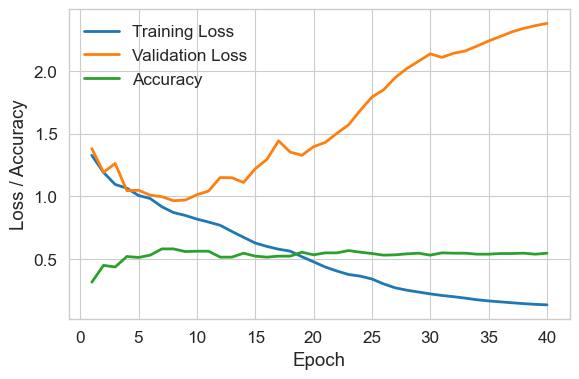

In [59]:
worst_model_name = "comp_classifier_0.0660402592179754-6_hdim36_param22826"
worst_model_loss = pd.read_csv(save_filepath+worst_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(worst_model_loss['Epoch'], worst_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(worst_model_loss['Epoch'], worst_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(worst_model_loss['Epoch'], worst_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

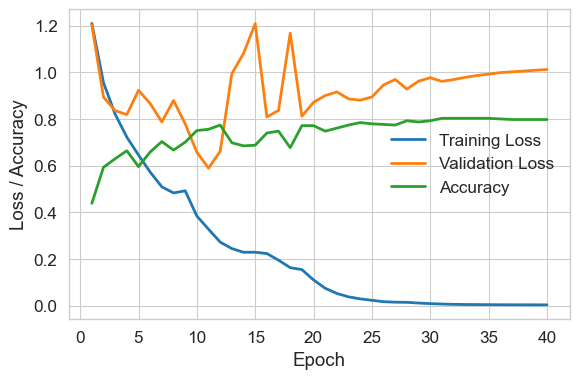

In [114]:
best_model_name = "comp_classifier_0.009587599554159203-9_hdim19_param19629"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(best_model_loss['Epoch'], best_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

#### Hyperparameter Analysis

In [60]:
from skopt.plots import plot_convergence, plot_gaussian_process, plot_evaluations, plot_objective, plot_objective_2D

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

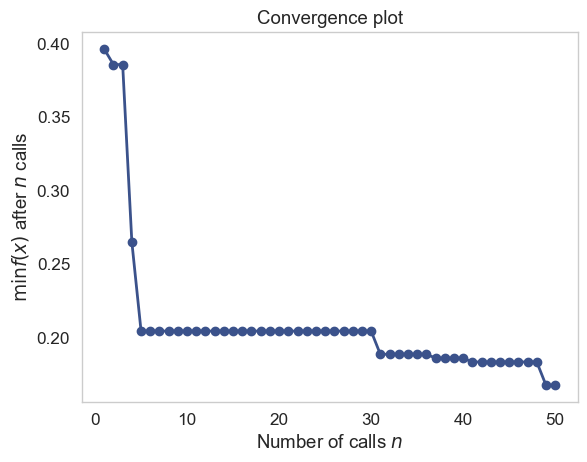

In [61]:
plot_convergence(param_result)

<Axes: >

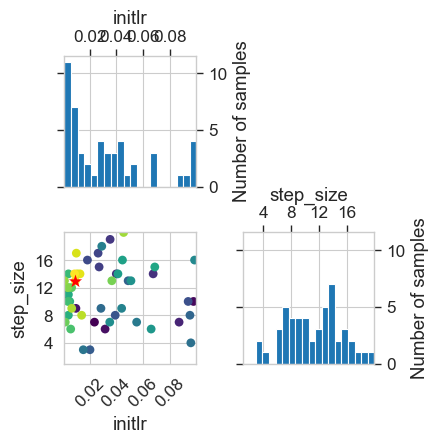

In [62]:
plot_evaluations(param_result)

<Axes: >

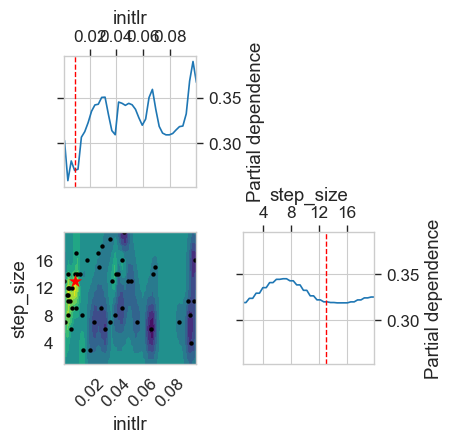

In [63]:
plot_objective(param_result)

<Axes: xlabel='initlr', ylabel='step_size'>

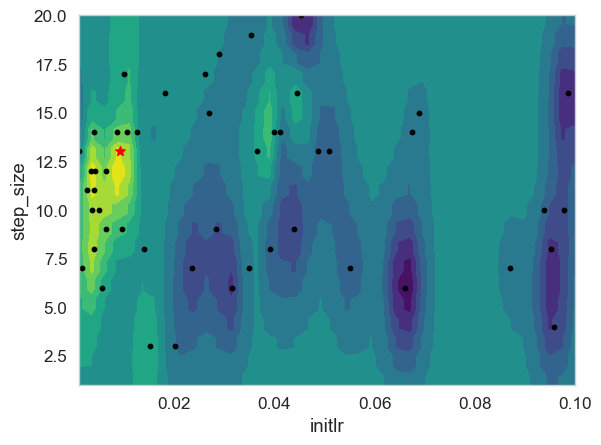

In [ ]:
plot_objective_2D(param_result, dimension_identifier1='initlr', dimension_identifier2='step_size')

#### Convolutional model hyperparameter search

In [127]:
import random
torch.cuda.empty_cache()
# single head model
# -1: tune all layers | 0: tune no layers | i : tune only the last i layers; [:-i] are frozen
# training hyperparameter search found: [0.009234786623517212, np.int64(13)]

# NOTE: this is currently not in use
tune_layers = -1
num_epochs = 40
batch_size = 64

initlr = 0.009234786623517212
step_size = 13
gamma = 0.5

save_filepath = "..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\"# + f'tune_layers_{tune_layers!=0}\\'

# bayesion parameter optimization
optim_name = 'testforblog'
checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

param_space = [
    Integer(8, 48, name='latent_dim'), # latent dimension
    Integer(8,  48, name='hidden_dim'), # hidden layer dimension
]

def objective_error(x):
    ldim, hdim = [int(p) for p in x]

    conv_cfg = {'input_shape':frames[0][0].shape[-2:], 'latent_dim':ldim, 'channels':[1, 8, 16], 'kernel':(10, 2)}
    conv = {'model': Conv(**conv_cfg), 'output_fn': 'encode', 'output_dim':ldim, 'tune_layers':tune_layers}

    comp_cfg = {
        'metadata':[conv_cfg],
        'hidden_dim':hdim,
        'num_epochs':num_epochs, 
        'batch_size':batch_size,
        'initlr':initlr
    }

    accuracy = train_and_save_comp_model(comp_cfg, model_list=[conv], dataset=frames, save_filepath=save_filepath, id=f"{'-'.join([str(int(p)) for p in x])}-r{random.randint(1, 50)}", step_size=step_size, gamma=gamma)
    print(f'Achieved final accuracy of {accuracy}')
    error = 1-accuracy
    return error

In [128]:
torch.cuda.empty_cache()
hyperparam_result = gp_minimize(
    objective_error, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=50, # total function calls
    n_initial_points=30, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4776275157928467
No existing log data found for comp_classifier_17-21-r26_hdim21_param18609 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_17-21-r26_hdim21_param18609')


Achieved final accuracy of 0.2729658782482147
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 32.1910
Function value obtained: 0.7270
Current minimum: 0.7270
Iteration No: 2 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4416313171386719
No existing log data found for comp_classifier_47-26-r44_hdim26_param34959 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_47-26-r44_hdim26_param34959')


Achieved final accuracy of 0.2808398902416229
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.6216
Function value obtained: 0.7192
Current minimum: 0.7192
Iteration No: 3 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3975169658660889
No existing log data found for comp_classifier_20-19-r40_hdim19_param20163 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_20-19-r40_hdim19_param20163')


Achieved final accuracy of 0.3097112774848938
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 31.4717
Function value obtained: 0.6903
Current minimum: 0.6903
Iteration No: 4 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4504244327545166
No existing log data found for comp_classifier_11-25-r28_hdim25_param15465 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_11-25-r28_hdim25_param15465')


Achieved final accuracy of 0.2729658782482147
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 32.2281
Function value obtained: 0.7270
Current minimum: 0.6903
Iteration No: 5 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5185301303863525
No existing log data found for comp_classifier_9-29-r32_hdim29_param14449 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_9-29-r32_hdim29_param14449')


Achieved final accuracy of 0.30708661675453186
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 33.1389
Function value obtained: 0.6929
Current minimum: 0.6903
Iteration No: 6 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4609150886535645
No existing log data found for comp_classifier_43-21-r47_hdim21_param32545 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_43-21-r47_hdim21_param32545')


Achieved final accuracy of 0.2808398902416229
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 34.4229
Function value obtained: 0.7192
Current minimum: 0.6903
Iteration No: 7 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.425473690032959
No existing log data found for comp_classifier_24-35-r32_hdim35_param22795 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_24-35-r32_hdim35_param22795')


Achieved final accuracy of 0.3018372654914856
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 34.9930
Function value obtained: 0.6982
Current minimum: 0.6903
Iteration No: 8 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.586021065711975
No existing log data found for comp_classifier_35-36-r1_hdim36_param28887 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_35-36-r1_hdim36_param28887')


Achieved final accuracy of 0.2860892415046692
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 35.3184
Function value obtained: 0.7139
Current minimum: 0.6903
Iteration No: 9 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5340299606323242
No existing log data found for comp_classifier_22-45-r29_hdim45_param21985 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_22-45-r29_hdim45_param21985')


Achieved final accuracy of 0.2335958033800125
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 35.2949
Function value obtained: 0.7664
Current minimum: 0.6903
Iteration No: 10 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3749706745147705
No existing log data found for comp_classifier_19-38-r49_hdim38_param20123 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_19-38-r49_hdim38_param20123')


Achieved final accuracy of 0.23622047901153564
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 35.3904
Function value obtained: 0.7638
Current minimum: 0.6903
Iteration No: 11 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3675358295440674
No existing log data found for comp_classifier_18-42-r46_hdim42_param19670 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_18-42-r46_hdim42_param19670')


Achieved final accuracy of 0.2939632534980774
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 35.7351
Function value obtained: 0.7060
Current minimum: 0.6903
Iteration No: 12 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.405140995979309
No existing log data found for comp_classifier_15-40-r39_hdim40_param17955 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_15-40-r39_hdim40_param17955')


Achieved final accuracy of 0.28871390223503113
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 36.6249
Function value obtained: 0.7113
Current minimum: 0.6903
Iteration No: 13 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5106803178787231
No existing log data found for comp_classifier_46-26-r40_hdim26_param34418 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_46-26-r40_hdim26_param34418')


Achieved final accuracy of 0.3097112774848938
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 36.7219
Function value obtained: 0.6903
Current minimum: 0.6903
Iteration No: 14 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5019690990447998
No existing log data found for comp_classifier_23-22-r29_hdim22_param21855 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_23-22-r29_hdim22_param21855')


Achieved final accuracy of 0.3044619560241699
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 36.1136
Function value obtained: 0.6955
Current minimum: 0.6903
Iteration No: 15 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.51334810256958
No existing log data found for comp_classifier_16-12-r27_hdim12_param17866 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_16-12-r27_hdim12_param17866')


Achieved final accuracy of 0.2650918662548065
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 36.5720
Function value obtained: 0.7349
Current minimum: 0.6903
Iteration No: 16 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.414851427078247
No existing log data found for comp_classifier_27-33-r48_hdim33_param24377 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_27-33-r48_hdim33_param24377')


Achieved final accuracy of 0.25984251499176025
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 36.8369
Function value obtained: 0.7402
Current minimum: 0.6903
Iteration No: 17 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5849764347076416
No existing log data found for comp_classifier_46-22-r6_hdim22_param34206 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_46-22-r6_hdim22_param34206')


Achieved final accuracy of 0.278215229511261
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 37.6565
Function value obtained: 0.7218
Current minimum: 0.6903
Iteration No: 18 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.486643671989441
No existing log data found for comp_classifier_19-26-r11_hdim26_param19811 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_19-26-r11_hdim26_param19811')


Achieved final accuracy of 0.25196850299835205
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 37.0219
Function value obtained: 0.7480
Current minimum: 0.6903
Iteration No: 19 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5132912397384644
No existing log data found for comp_classifier_46-15-r34_hdim15_param33835 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_46-15-r34_hdim15_param33835')


Achieved final accuracy of 0.27559053897857666
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 37.2457
Function value obtained: 0.7244
Current minimum: 0.6903
Iteration No: 20 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4635231494903564
No existing log data found for comp_classifier_14-11-r45_hdim11_param16791 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_14-11-r45_hdim11_param16791')


Achieved final accuracy of 0.28346455097198486
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 37.0016
Function value obtained: 0.7165
Current minimum: 0.6903
Iteration No: 21 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5123201608657837
No existing log data found for comp_classifier_30-20-r12_hdim20_param25540 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_30-20-r12_hdim20_param25540')


Achieved final accuracy of 0.2939632534980774
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 37.8162
Function value obtained: 0.7060
Current minimum: 0.6903
Iteration No: 22 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.445072889328003
No existing log data found for comp_classifier_19-45-r28_hdim45_param20305 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_19-45-r28_hdim45_param20305')


Achieved final accuracy of 0.25984251499176025
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 37.0863
Function value obtained: 0.7402
Current minimum: 0.6903
Iteration No: 23 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4109731912612915
No existing log data found for comp_classifier_25-25-r40_hdim25_param23025 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_25-25-r40_hdim25_param23025')


Achieved final accuracy of 0.23622047901153564
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 38.5852
Function value obtained: 0.7638
Current minimum: 0.6903
Iteration No: 24 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4251291751861572
No existing log data found for comp_classifier_47-40-r28_hdim40_param35715 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_47-40-r28_hdim40_param35715')


Achieved final accuracy of 0.2572178542613983
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 38.4821
Function value obtained: 0.7428
Current minimum: 0.6903
Iteration No: 25 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.377168893814087
No existing log data found for comp_classifier_22-20-r43_hdim20_param21260 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_22-20-r43_hdim20_param21260')


Achieved final accuracy of 0.2703412175178528
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 38.0460
Function value obtained: 0.7297
Current minimum: 0.6903
Iteration No: 26 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.334427833557129
No existing log data found for comp_classifier_28-33-r1_hdim33_param24925 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_28-33-r1_hdim33_param24925')


Achieved final accuracy of 0.2703412175178528
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 38.2742
Function value obtained: 0.7297
Current minimum: 0.6903
Iteration No: 27 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4253129959106445
No existing log data found for comp_classifier_34-18-r40_hdim18_param27598 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_34-18-r40_hdim18_param27598')


Achieved final accuracy of 0.28346455097198486
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 38.0780
Function value obtained: 0.7165
Current minimum: 0.6903
Iteration No: 28 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4388036727905273
No existing log data found for comp_classifier_24-35-r24_hdim35_param22795 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_24-35-r24_hdim35_param22795')


Achieved final accuracy of 0.27559053897857666
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 38.5675
Function value obtained: 0.7244
Current minimum: 0.6903
Iteration No: 29 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4461369514465332
No existing log data found for comp_classifier_26-39-r7_hdim39_param24027 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_26-39-r7_hdim39_param24027')


Achieved final accuracy of 0.32283464074134827
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 38.4275
Function value obtained: 0.6772
Current minimum: 0.6772
Iteration No: 30 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.406775951385498
No existing log data found for comp_classifier_35-37-r44_hdim37_param28929 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_35-37-r44_hdim37_param28929')


Achieved final accuracy of 0.2703412175178528
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 38.7280
Function value obtained: 0.7297
Current minimum: 0.6772
Iteration No: 31 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3984229564666748
No existing log data found for comp_classifier_27-40-r17_hdim40_param24615 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_27-40-r17_hdim40_param24615')


Achieved final accuracy of 0.26771652698516846
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 39.0526
Function value obtained: 0.7323
Current minimum: 0.6772
Iteration No: 32 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4179582595825195
No existing log data found for comp_classifier_25-39-r17_hdim39_param23473 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_25-39-r17_hdim39_param23473')


Achieved final accuracy of 0.3044619560241699
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 38.5014
Function value obtained: 0.6955
Current minimum: 0.6772
Iteration No: 33 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4381299018859863
No existing log data found for comp_classifier_44-39-r30_hdim39_param33999 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_44-39-r30_hdim39_param33999')


Achieved final accuracy of 0.278215229511261
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 39.4113
Function value obtained: 0.7218
Current minimum: 0.6772
Iteration No: 34 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.449653148651123
No existing log data found for comp_classifier_26-38-r45_hdim38_param23994 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_26-38-r45_hdim38_param23994')


Achieved final accuracy of 0.2467191517353058
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 39.2985
Function value obtained: 0.7533
Current minimum: 0.6772
Iteration No: 35 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5025615692138672
No existing log data found for comp_classifier_26-40-r9_hdim40_param24060 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_26-40-r9_hdim40_param24060')


Achieved final accuracy of 0.25984251499176025
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 39.1052
Function value obtained: 0.7402
Current minimum: 0.6772
Iteration No: 36 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.402614712715149
No existing log data found for comp_classifier_48-8-r28_hdim8_param34510 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_48-8-r28_hdim8_param34510')


Achieved final accuracy of 0.254593163728714
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 39.4501
Function value obtained: 0.7454
Current minimum: 0.6772
Iteration No: 37 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4760856628417969
No existing log data found for comp_classifier_44-26-r7_hdim26_param33336 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_44-26-r7_hdim26_param33336')


Achieved final accuracy of 0.2650918662548065
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 40.3598
Function value obtained: 0.7349
Current minimum: 0.6772
Iteration No: 38 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5805463790893555
No existing log data found for comp_classifier_48-48-r44_hdim48_param36710 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_48-48-r44_hdim48_param36710')


Achieved final accuracy of 0.28346455097198486
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 39.4457
Function value obtained: 0.7165
Current minimum: 0.6772
Iteration No: 39 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.38795006275177
No existing log data found for comp_classifier_29-39-r14_hdim39_param25689 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_29-39-r14_hdim39_param25689')


Achieved final accuracy of 0.2939632534980774
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 36.6008
Function value obtained: 0.7060
Current minimum: 0.6772
Iteration No: 40 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3629844188690186
No existing log data found for comp_classifier_20-18-r50_hdim18_param20136 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_20-18-r50_hdim18_param20136')


Achieved final accuracy of 0.26771652698516846
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 37.8818
Function value obtained: 0.7323
Current minimum: 0.6772
Iteration No: 41 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4290071725845337
No existing log data found for comp_classifier_20-20-r38_hdim20_param20190 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_20-20-r38_hdim20_param20190')


Achieved final accuracy of 0.3018372654914856
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 37.9617
Function value obtained: 0.6982
Current minimum: 0.6772
Iteration No: 42 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4458177089691162
No existing log data found for comp_classifier_8-33-r39_hdim33_param13965 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_8-33-r39_hdim33_param13965')


Achieved final accuracy of 0.23884513974189758
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 36.8629
Function value obtained: 0.7612
Current minimum: 0.6772
Iteration No: 43 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4284992218017578
No existing log data found for comp_classifier_8-27-r40_hdim27_param13875 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_8-27-r40_hdim27_param13875')


Achieved final accuracy of 0.3123359680175781
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 37.9484
Function value obtained: 0.6877
Current minimum: 0.6772
Iteration No: 44 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3634705543518066
No existing log data found for comp_classifier_27-8-r28_hdim8_param23527 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_27-8-r28_hdim8_param23527')


Achieved final accuracy of 0.2729658782482147
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 38.0926
Function value obtained: 0.7270
Current minimum: 0.6772
Iteration No: 45 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4365824460983276
No existing log data found for comp_classifier_34-30-r22_hdim30_param28090 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_34-30-r22_hdim30_param28090')


Achieved final accuracy of 0.2572178542613983
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 37.9506
Function value obtained: 0.7428
Current minimum: 0.6772
Iteration No: 46 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4923535585403442
No existing log data found for comp_classifier_10-41-r11_hdim41_param15197 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_10-41-r11_hdim41_param15197')


Achieved final accuracy of 0.27559053897857666
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 38.1006
Function value obtained: 0.7244
Current minimum: 0.6772
Iteration No: 47 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5303208827972412
No existing log data found for comp_classifier_8-28-r38_hdim28_param13890 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_8-28-r38_hdim28_param13890')


Achieved final accuracy of 0.30708661675453186
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 37.5640
Function value obtained: 0.6929
Current minimum: 0.6772
Iteration No: 48 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5329394340515137
No existing log data found for comp_classifier_39-8-r37_hdim8_param29803 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_39-8-r37_hdim8_param29803')


Achieved final accuracy of 0.22572177648544312
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 37.9086
Function value obtained: 0.7743
Current minimum: 0.6772
Iteration No: 49 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3706202507019043
No existing log data found for comp_classifier_23-36-r47_hdim36_param22275 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_23-36-r47_hdim36_param22275')


Achieved final accuracy of 0.2860892415046692
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 37.7853
Function value obtained: 0.7139
Current minimum: 0.6772
Iteration No: 50 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4326064586639404
No existing log data found for comp_classifier_11-28-r41_hdim28_param15519 in ..\saved_models\cognitive_workload\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\conv\\ldim_hdim\\', 'comp_classifier_11-28-r41_hdim28_param15519')


Achieved final accuracy of 0.2729658782482147
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 37.9797
Function value obtained: 0.7270
Current minimum: 0.6772


In [130]:
hyperparam_result.x, hyperparam_result.fun

([np.int64(26), np.int64(39)], np.float64(0.6771653592586517))

In [134]:
hyperparam_result.x_iters[47]

[np.int64(39), np.int64(8)]

In [101]:
objective_error([26, 31])

Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4373753070831299
No existing log data found for comp_classifier_26-31-r40_hdim31_param23763 in ..\saved_models\conv\ldim_hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\conv\\ldim_hdim\\', 'comp_classifier_26-31-r40_hdim31_param23763')


Epoch 1/40 [Training]:   0%|          | 0/48 [00:00<?, ?it/s]

Achieved final accuracy of 0.6771653294563293


0.32283467054367065

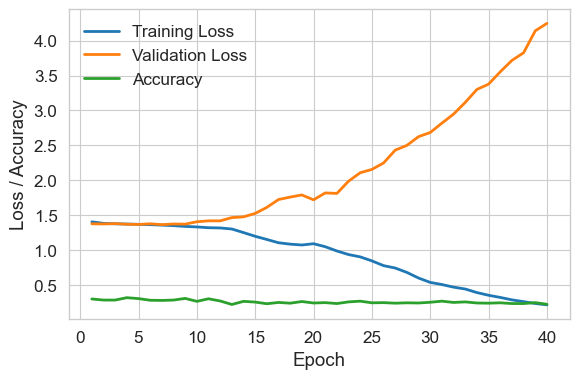

In [135]:
worst_model_name = "comp_classifier_39-8-r37_hdim8_param29803"
worst_model_loss = pd.read_csv(save_filepath+worst_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(worst_model_loss['Epoch'], worst_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(worst_model_loss['Epoch'], worst_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(worst_model_loss['Epoch'], worst_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

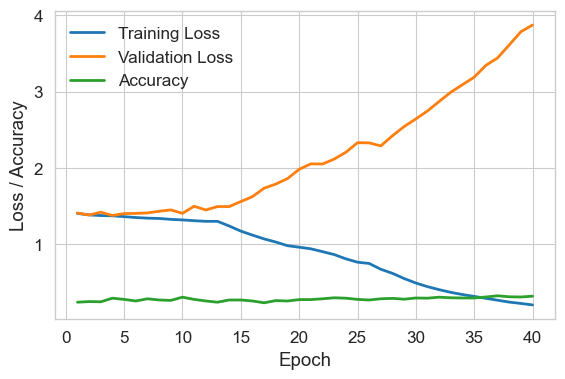

In [131]:
best_model_name = "comp_classifier_26-39-r7_hdim39_param24027"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(best_model_loss['Epoch'], best_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

#### Hyperparameter Analysis

In [136]:
from skopt.plots import plot_convergence, plot_gaussian_process, plot_evaluations, plot_objective, plot_objective_2D

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

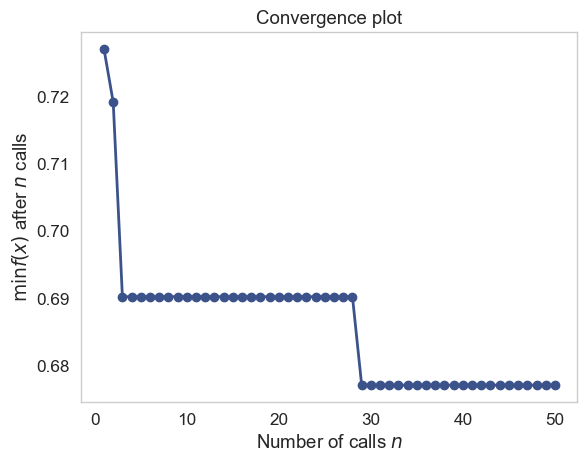

In [137]:
plot_convergence(hyperparam_result)

<Axes: >

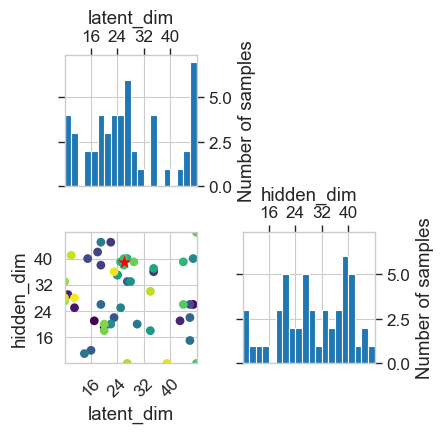

In [138]:
plot_evaluations(hyperparam_result)

<Axes: >

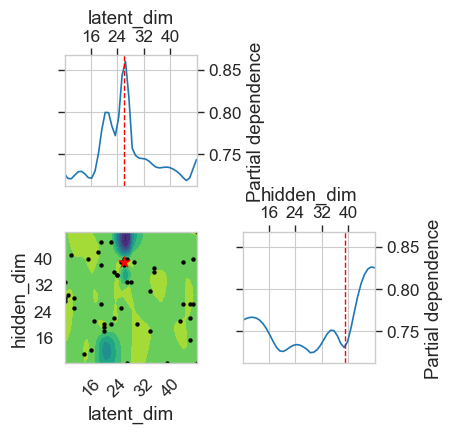

In [139]:
plot_objective(hyperparam_result)

<Axes: xlabel='latent_dim', ylabel='hidden_dim'>

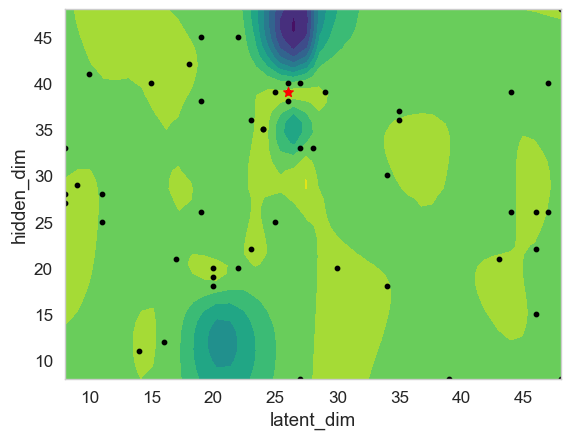

In [140]:
plot_objective_2D(hyperparam_result, dimension_identifier1='latent_dim', dimension_identifier2='hidden_dim')

#### Candidate Feature Model

In [ ]:
torch.cuda.empty_cache()
# single head model
# -1: tune all layers | 0: tune no layers | i : tune only the last i layers; [:-i] are frozen
tune_layers = 0
num_epochs = 40
batch_size = 64
initlr = 1e-2
step_size = 15
gamma = 0.5

save_filepath = "..\\saved_models\\cognitive_workload\\stat\\hdim\\"# + f'tune_layers_{tune_layers!=0}\\'

# bayesion parameter optimization
optim_name = 'testforblog'
checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

param_space = [
    Integer(8,  48, name='hidden_dim'), # hidden layer dimension
]

def objective_error(x):
    hdim = int(x[0])

    stats_cfg = {'cand_features':None}
    stats = {'model':StatFeatures(**stats_cfg), 'output_fn':'compute', 'output_dim':25, 'tune_layers':tune_layers}

    comp_cfg = {
        'metadata':[stats_cfg],
        'hidden_dim':hdim,
        'num_epochs':num_epochs, 
        'batch_size':batch_size,
        'initlr':initlr
    }

    accuracy = train_and_save_comp_model(comp_cfg, model_list=[stats], dataset=frames, save_filepath=save_filepath, id=f"{'-'.join([str(int(p)) for p in x])}", step_size=step_size, gamma=gamma)
    print(f'Achieved final accuracy of {accuracy}')
    error = 1-accuracy
    return error

In [44]:
torch.cuda.empty_cache()
hyperparam_stat_result = gp_minimize(
    objective_error, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=30, # total function calls
    n_initial_points=10, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4844528436660767
No existing log data found for comp_classifier_17_hdim17_param548 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_17_hdim17_param548')


Achieved final accuracy of 0.5590550899505615
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.4806
Function value obtained: 0.4409
Current minimum: 0.4409
Iteration No: 2 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4441938400268555
No existing log data found for comp_classifier_21_hdim21_param676 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_21_hdim21_param676')


Achieved final accuracy of 0.5774278044700623
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.5865
Function value obtained: 0.4226
Current minimum: 0.4226
Iteration No: 3 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4938777685165405
No existing log data found for comp_classifier_47_hdim47_param1508 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_47_hdim47_param1508')


Achieved final accuracy of 0.5538057684898376
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.2280
Function value obtained: 0.4462
Current minimum: 0.4226
Iteration No: 4 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4179127216339111
No existing log data found for comp_classifier_26_hdim26_param836 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_26_hdim26_param836')


Achieved final accuracy of 0.5643044710159302
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.8937
Function value obtained: 0.4357
Current minimum: 0.4226
Iteration No: 5 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4528477191925049
No existing log data found for comp_classifier_20_hdim20_param644 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_20_hdim20_param644')


Achieved final accuracy of 0.5879265069961548
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.0027
Function value obtained: 0.4121
Current minimum: 0.4121
Iteration No: 6 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.473805546760559
No existing log data found for comp_classifier_19_hdim19_param612 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_19_hdim19_param612')


Achieved final accuracy of 0.5748031735420227
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.9491
Function value obtained: 0.4252
Current minimum: 0.4121
Iteration No: 7 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4793236255645752
No existing log data found for comp_classifier_11_hdim11_param356 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_11_hdim11_param356')


Achieved final accuracy of 0.5931758284568787
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 12.9055
Function value obtained: 0.4068
Current minimum: 0.4068
Iteration No: 8 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3653807640075684
No existing log data found for comp_classifier_25_hdim25_param804 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_25_hdim25_param804')


Achieved final accuracy of 0.5853018164634705
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.9570
Function value obtained: 0.4147
Current minimum: 0.4068
Iteration No: 9 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3692878484725952
No existing log data found for comp_classifier_9_hdim9_param292 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_9_hdim9_param292')


Achieved final accuracy of 0.5590550899505615
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.9457
Function value obtained: 0.4409
Current minimum: 0.4068
Iteration No: 10 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5076228380203247
No existing log data found for comp_classifier_29_hdim29_param932 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_29_hdim29_param932')


Achieved final accuracy of 0.6089239120483398


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(29)] before, using random point [np.int64(28)]
  warnings.warn(


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 13.2535
Function value obtained: 0.3911
Current minimum: 0.3911
Iteration No: 11 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4635409116744995
No existing log data found for comp_classifier_28_hdim28_param900 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_28_hdim28_param900')


Achieved final accuracy of 0.5931758284568787
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 13.0407
Function value obtained: 0.4068
Current minimum: 0.3911
Iteration No: 12 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4803777933120728
No existing log data found for comp_classifier_30_hdim30_param964 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_30_hdim30_param964')


Achieved final accuracy of 0.5459317564964294
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.1795
Function value obtained: 0.4541
Current minimum: 0.3911
Iteration No: 13 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.350419282913208
No existing log data found for comp_classifier_12_hdim12_param388 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_12_hdim12_param388')


Achieved final accuracy of 0.5853018164634705
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.2806
Function value obtained: 0.4147
Current minimum: 0.3911
Iteration No: 14 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.368435263633728
No existing log data found for comp_classifier_24_hdim24_param772 in ..\saved_models\stat\hdim\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\stat\\hdim\\', 'comp_classifier_24_hdim24_param772')


Achieved final accuracy of 0.6010498404502869
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.2124
Function value obtained: 0.3990
Current minimum: 0.3911
Iteration No: 15 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4374170303344727


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(9)]
  warnings.warn(


Exception: Model name exists in directory! Choose another ID

In [68]:
# results
res = skopt.load("../saved_models/stat/hdim/testforblog.pkl")
print(f'Hyperparameter space [hdim]: \n {res.space}')
print(f'Best hyperparameters: {res.x}')
print(f'Best objective function value: {res.fun}')
worst_index = np.argmax(res.func_vals)
print(f'Worst Hyperparameters: {res.x_iters[worst_index]}')
print(f'Worst objective function value: {res.func_vals[worst_index]}')

Hyperparameter space [hdim]: 
 Space([Integer(low=8, high=48, prior='uniform', transform='normalize')])
Best hyperparameters: [np.int64(29)]
Best objective function value: 0.39107608795166016
Worst Hyperparameters: [np.int64(30)]
Worst objective function value: 0.45406824350357056


In [141]:
torch.cuda.empty_cache()
# single head model
# -1: tune all layers | 0: tune no layers | i : tune only the last i layers; [:-i] are frozen
# NOTE: this argument is no longer in use
tune_layers = 0
num_epochs = 40
batch_size = 64
# initlr = 1e-2
# step_size = 15
gamma = 0.5

save_filepath = "..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\"# + f'tune_layers_{tune_layers!=0}\\'

# bayesion parameter optimization
optim_name = 'testforblog'
checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

param_space = [
    Real(1e-3, 1e-1, name='initlr'), # latent dimension
    Integer(1,  20, name='step_size'), 
]

def objective_error_param_search(x):
    initlr, step_size = float(x[0]), int(x[1])

    stats_cfg = {'cand_features':None}
    stats = {'model':StatFeatures(**stats_cfg), 'output_fn':'compute', 'output_dim':25, 'tune_layers':tune_layers}

    comp_cfg = {
        'metadata':[stats_cfg],
        'hidden_dim':30,
        'num_epochs':num_epochs, 
        'batch_size':batch_size,
        'initlr':initlr
    }

    accuracy = train_and_save_comp_model(comp_cfg, model_list=[stats], dataset=frames, save_filepath=save_filepath, id=f"{'-'.join([str(initlr), str(step_size)])}", step_size=step_size, gamma=gamma)
    print(f'Achieved final accuracy of {accuracy}')
    error = 1-accuracy
    return error

In [142]:
torch.cuda.empty_cache()
param_stat_result = gp_minimize(
    objective_error_param_search, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=50, # total function calls
    n_initial_points=30, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4129868745803833
No existing log data found for comp_classifier_0.02350656890282006-7_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.02350656890282006-7_hdim30_param964')


Achieved final accuracy of 0.2860892415046692
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.3654
Function value obtained: 0.7139
Current minimum: 0.7139
Iteration No: 2 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3957231044769287
No existing log data found for comp_classifier_0.09784406681077969-10_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.09784406681077969-10_hdim30_param964')


Achieved final accuracy of 0.28871390223503113
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.2182
Function value obtained: 0.7113
Current minimum: 0.7113
Iteration No: 3 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4929378032684326
No existing log data found for comp_classifier_0.0314932637535862-6_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0314932637535862-6_hdim30_param964')


Achieved final accuracy of 0.2624672055244446
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.2572
Function value obtained: 0.7375
Current minimum: 0.7113
Iteration No: 4 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3184700012207031
No existing log data found for comp_classifier_0.009587599554159203-9_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.009587599554159203-9_hdim30_param964')


Achieved final accuracy of 0.254593163728714
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.6674
Function value obtained: 0.7454
Current minimum: 0.7113
Iteration No: 5 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.497018575668335
No existing log data found for comp_classifier_0.0025751257351664192-11_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0025751257351664192-11_hdim30_param964')


Achieved final accuracy of 0.28871390223503113
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.9169
Function value obtained: 0.7113
Current minimum: 0.7113
Iteration No: 6 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4200692176818848
No existing log data found for comp_classifier_0.08701134436257309-7_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.08701134436257309-7_hdim30_param964')


Achieved final accuracy of 0.29133859276771545
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 13.9116
Function value obtained: 0.7087
Current minimum: 0.7087
Iteration No: 7 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.420423984527588
No existing log data found for comp_classifier_0.03990128867721334-14_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.03990128867721334-14_hdim30_param964')


Achieved final accuracy of 0.2939632534980774
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.9615
Function value obtained: 0.7060
Current minimum: 0.7060
Iteration No: 8 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.449023962020874
No existing log data found for comp_classifier_0.0675594100508821-14_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0675594100508821-14_hdim30_param964')


Achieved final accuracy of 0.29921260476112366
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 13.8385
Function value obtained: 0.7008
Current minimum: 0.7008
Iteration No: 9 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.349606990814209
No existing log data found for comp_classifier_0.0352513206881305-19_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0352513206881305-19_hdim30_param964')


Achieved final accuracy of 0.28871390223503113
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 17.9043
Function value obtained: 0.7113
Current minimum: 0.7008
Iteration No: 10 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5097200870513916
No existing log data found for comp_classifier_0.026995793234296316-15_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.026995793234296316-15_hdim30_param964')


Achieved final accuracy of 0.29133859276771545
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 17.6882
Function value obtained: 0.7087
Current minimum: 0.7008
Iteration No: 11 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3528265953063965
No existing log data found for comp_classifier_0.026234512188008582-17_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.026234512188008582-17_hdim30_param964')


Achieved final accuracy of 0.2729658782482147
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.6693
Function value obtained: 0.7270
Current minimum: 0.7008
Iteration No: 12 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.459510087966919
No existing log data found for comp_classifier_0.018231223645064996-16_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.018231223645064996-16_hdim30_param964')


Achieved final accuracy of 0.23884513974189758
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 15.0021
Function value obtained: 0.7612
Current minimum: 0.7008
Iteration No: 13 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4531261920928955
No existing log data found for comp_classifier_0.09382530422645642-10_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.09382530422645642-10_hdim30_param964')


Achieved final accuracy of 0.21259842813014984
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 19.5894
Function value obtained: 0.7874
Current minimum: 0.7008
Iteration No: 14 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3521784543991089
No existing log data found for comp_classifier_0.039080306979198585-8_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.039080306979198585-8_hdim30_param964')


Achieved final accuracy of 0.27559053897857666
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 23.0632
Function value obtained: 0.7244
Current minimum: 0.7008
Iteration No: 15 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5011191368103027
No existing log data found for comp_classifier_0.02014220671584855-3_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.02014220671584855-3_hdim30_param964')


Achieved final accuracy of 0.29133859276771545
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 21.7460
Function value obtained: 0.7087
Current minimum: 0.7008
Iteration No: 16 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.448943853378296
No existing log data found for comp_classifier_0.048781053338839295-13_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.048781053338839295-13_hdim30_param964')


Achieved final accuracy of 0.3123359680175781
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 27.0431
Function value obtained: 0.6877
Current minimum: 0.6877
Iteration No: 17 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4545128345489502
No existing log data found for comp_classifier_0.09517358604269265-8_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.09517358604269265-8_hdim30_param964')


Achieved final accuracy of 0.28871390223503113
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 21.2601
Function value obtained: 0.7113
Current minimum: 0.6877
Iteration No: 18 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4030309915542603
No existing log data found for comp_classifier_0.02837495607103319-9_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.02837495607103319-9_hdim30_param964')


Achieved final accuracy of 0.29133859276771545
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 20.9476
Function value obtained: 0.7087
Current minimum: 0.6877
Iteration No: 19 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4012647867202759
No existing log data found for comp_classifier_0.09583345916185883-4_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.09583345916185883-4_hdim30_param964')


Achieved final accuracy of 0.2939632534980774
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 20.3841
Function value obtained: 0.7060
Current minimum: 0.6877
Iteration No: 20 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4969593286514282
No existing log data found for comp_classifier_0.015128858926362218-3_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.015128858926362218-3_hdim30_param964')


Achieved final accuracy of 0.3018372654914856
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 20.4630
Function value obtained: 0.6982
Current minimum: 0.6877
Iteration No: 21 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.456681251525879
No existing log data found for comp_classifier_0.055176277517861576-7_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.055176277517861576-7_hdim30_param964')


Achieved final accuracy of 0.26771652698516846
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 20.4203
Function value obtained: 0.7323
Current minimum: 0.6877
Iteration No: 22 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.505767583847046
No existing log data found for comp_classifier_0.02898925293732254-18_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.02898925293732254-18_hdim30_param964')


Achieved final accuracy of 0.2650918662548065
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 21.2491
Function value obtained: 0.7349
Current minimum: 0.6877
Iteration No: 23 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4383764266967773
No existing log data found for comp_classifier_0.04390087425122476-9_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.04390087425122476-9_hdim30_param964')


Achieved final accuracy of 0.2729658782482147
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 21.1839
Function value obtained: 0.7270
Current minimum: 0.6877
Iteration No: 24 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4851605892181396
No existing log data found for comp_classifier_0.09863609141659667-16_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.09863609141659667-16_hdim30_param964')


Achieved final accuracy of 0.21259842813014984
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 21.1908
Function value obtained: 0.7874
Current minimum: 0.6877
Iteration No: 25 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4889593124389648
No existing log data found for comp_classifier_0.03498720505364812-7_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.03498720505364812-7_hdim30_param964')


Achieved final accuracy of 0.25984251499176025
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 22.4607
Function value obtained: 0.7402
Current minimum: 0.6877
Iteration No: 26 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4932398796081543
No existing log data found for comp_classifier_0.05089155924483318-13_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.05089155924483318-13_hdim30_param964')


Achieved final accuracy of 0.29658791422843933
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 21.4234
Function value obtained: 0.7034
Current minimum: 0.6877
Iteration No: 27 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.51790189743042
No existing log data found for comp_classifier_0.0660402592179754-6_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0660402592179754-6_hdim30_param964')


Achieved final accuracy of 0.29921260476112366
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 22.4282
Function value obtained: 0.7008
Current minimum: 0.6877
Iteration No: 28 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5068390369415283
No existing log data found for comp_classifier_0.04111470677808868-14_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.04111470677808868-14_hdim30_param964')


Achieved final accuracy of 0.2703412175178528
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 23.6222
Function value obtained: 0.7297
Current minimum: 0.6877
Iteration No: 29 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4301860332489014
No existing log data found for comp_classifier_0.04451063000582192-16_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.04451063000582192-16_hdim30_param964')


Achieved final accuracy of 0.3097112774848938
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 22.7998
Function value obtained: 0.6903
Current minimum: 0.6877
Iteration No: 30 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5073518753051758
No existing log data found for comp_classifier_0.06877826347142374-15_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.06877826347142374-15_hdim30_param964')


Achieved final accuracy of 0.30708661675453186
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 23.7985
Function value obtained: 0.6929
Current minimum: 0.6877
Iteration No: 31 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4261069297790527
No existing log data found for comp_classifier_0.04900910488279257-14_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.04900910488279257-14_hdim30_param964')


Achieved final accuracy of 0.28346455097198486
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 16.4838
Function value obtained: 0.7165
Current minimum: 0.6877
Iteration No: 32 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4425809383392334
No existing log data found for comp_classifier_0.049153722420100215-13_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.049153722420100215-13_hdim30_param964')


Achieved final accuracy of 0.28346455097198486
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 16.3803
Function value obtained: 0.7165
Current minimum: 0.6877
Iteration No: 33 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3940845727920532
No existing log data found for comp_classifier_0.04844682916419898-13_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.04844682916419898-13_hdim30_param964')


Achieved final accuracy of 0.2703412175178528
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 16.0556
Function value obtained: 0.7297
Current minimum: 0.6877
Iteration No: 34 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5448260307312012
No existing log data found for comp_classifier_0.0522500235981938-13_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0522500235981938-13_hdim30_param964')


Achieved final accuracy of 0.3123359680175781
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 15.0126
Function value obtained: 0.6877
Current minimum: 0.6877
Iteration No: 35 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.401188850402832
No existing log data found for comp_classifier_0.0517181139540699-12_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.0517181139540699-12_hdim30_param964')


Achieved final accuracy of 0.3044619560241699
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 25.3827
Function value obtained: 0.6955
Current minimum: 0.6877
Iteration No: 36 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4177104234695435
No existing log data found for comp_classifier_0.05188817681878877-16_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.05188817681878877-16_hdim30_param964')


Achieved final accuracy of 0.2939632534980774
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 23.2022
Function value obtained: 0.7060
Current minimum: 0.6877
Iteration No: 37 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4561278820037842
No existing log data found for comp_classifier_0.04883704812156022-12_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.04883704812156022-12_hdim30_param964')


Achieved final accuracy of 0.2729658782482147
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 24.2886
Function value obtained: 0.7270
Current minimum: 0.6877
Iteration No: 38 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4187192916870117
No existing log data found for comp_classifier_0.05169634084632701-14_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.05169634084632701-14_hdim30_param964')


Achieved final accuracy of 0.29658791422843933
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 23.1177
Function value obtained: 0.7034
Current minimum: 0.6877
Iteration No: 39 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3703758716583252
No existing log data found for comp_classifier_0.053196415319575384-12_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.053196415319575384-12_hdim30_param964')


Achieved final accuracy of 0.29133859276771545
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 21.1086
Function value obtained: 0.7087
Current minimum: 0.6877
Iteration No: 40 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5784580707550049
No existing log data found for comp_classifier_0.044331882191543937-18_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.044331882191543937-18_hdim30_param964')


Achieved final accuracy of 0.26771652698516846
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 14.6346
Function value obtained: 0.7323
Current minimum: 0.6877
Iteration No: 41 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.451772928237915
No existing log data found for comp_classifier_0.044497462764681056-15_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.044497462764681056-15_hdim30_param964')


Achieved final accuracy of 0.2860892415046692
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 14.0890
Function value obtained: 0.7139
Current minimum: 0.6877
Iteration No: 42 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.370523452758789
No existing log data found for comp_classifier_0.06905138987483582-13_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.06905138987483582-13_hdim30_param964')


Achieved final accuracy of 0.29133859276771545
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 14.5354
Function value obtained: 0.7087
Current minimum: 0.6877
Iteration No: 43 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.377752661705017
No existing log data found for comp_classifier_0.06805475318974538-16_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.06805475318974538-16_hdim30_param964')


Achieved final accuracy of 0.3044619560241699
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 15.8489
Function value obtained: 0.6955
Current minimum: 0.6877
Iteration No: 44 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3684115409851074
No existing log data found for comp_classifier_0.06947573853535888-17_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.06947573853535888-17_hdim30_param964')


Achieved final accuracy of 0.3018372654914856
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 14.6377
Function value obtained: 0.6982
Current minimum: 0.6877
Iteration No: 45 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4089535474777222
No existing log data found for comp_classifier_0.07023262258397503-15_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.07023262258397503-15_hdim30_param964')


Achieved final accuracy of 0.3044619560241699
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 14.3053
Function value obtained: 0.6955
Current minimum: 0.6877
Iteration No: 46 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4843723773956299
No existing log data found for comp_classifier_0.07124571850157034-17_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.07124571850157034-17_hdim30_param964')


Achieved final accuracy of 0.2939632534980774
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 14.3404
Function value obtained: 0.7060
Current minimum: 0.6877
Iteration No: 47 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4442877769470215
No existing log data found for comp_classifier_0.053193319111110936-15_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.053193319111110936-15_hdim30_param964')


Achieved final accuracy of 0.3097112774848938
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 14.3153
Function value obtained: 0.6903
Current minimum: 0.6877
Iteration No: 48 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3623175621032715
No existing log data found for comp_classifier_0.05371162843374846-17_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.05371162843374846-17_hdim30_param964')


Achieved final accuracy of 0.3385826647281647
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 14.3346
Function value obtained: 0.6614
Current minimum: 0.6614
Iteration No: 49 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3851608037948608
No existing log data found for comp_classifier_0.05439503315790757-17_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.05439503315790757-17_hdim30_param964')


Achieved final accuracy of 0.30708661675453186
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 14.2839
Function value obtained: 0.6929
Current minimum: 0.6614
Iteration No: 50 started. Searching for the next optimal point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4058806896209717
No existing log data found for comp_classifier_0.05329745945715067-17_hdim30_param964 in ..\saved_models\cognitive_workload\stat\initlr_stepsize\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\cognitive_workload\\stat\\initlr_stepsize\\', 'comp_classifier_0.05329745945715067-17_hdim30_param964')


Achieved final accuracy of 0.3044619560241699
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 14.5679
Function value obtained: 0.6955
Current minimum: 0.6614


In [144]:
param_stat_result.x, param_stat_result.fun

([0.05371162843374846, np.int64(17)], np.float64(0.6614173352718353))

In [148]:
param_stat_result.x_iters[12]

[0.09382530422645642, np.int64(10)]

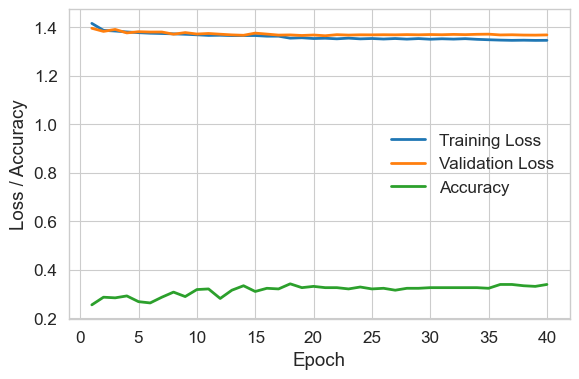

In [145]:
best_model_name = "comp_classifier_0.05371162843374846-17_hdim30_param964"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(best_model_loss['Epoch'], best_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

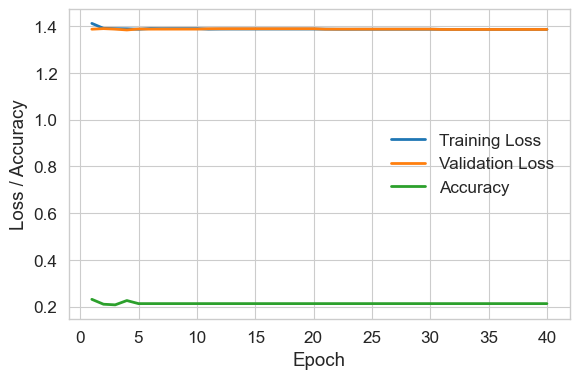

In [149]:


best_model_name = "comp_classifier_0.09382530422645642-10_hdim30_param964"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(best_model_loss['Epoch'], best_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

In [119]:
from skopt.plots import plot_convergence, plot_gaussian_process, plot_evaluations, plot_objective, plot_objective_2D

<Axes: >

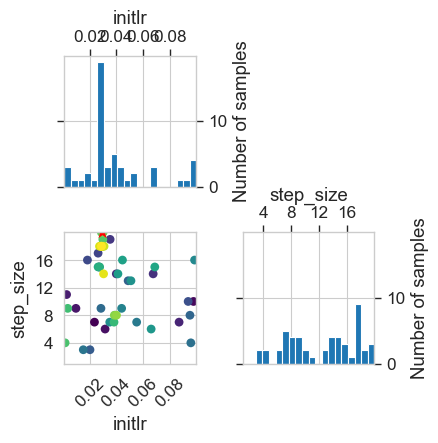

In [120]:
plot_evaluations(param_stat_result)

<Axes: >

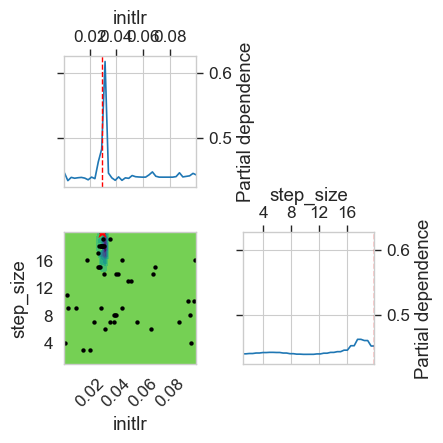

In [121]:
plot_objective(param_stat_result)

In [12]:
# launches tensorboard at localhost:6006
#tensorboard --logdir=saved_models\\classifier\\bayes_opt4\\tensorboard_logs
%reload_ext tensorboard
%tensorboard --logdir=f"{save_filepath}+tensorboard_logs"

Reusing TensorBoard on port 6006 (pid 15184), started 1:38:00 ago. (Use '!kill 15184' to kill it.)

### Ablative Analysis: Top-n composite model

In [26]:
torch.cuda.empty_cache()
# single head model
# -1: tune all layers | 0: tune no layers | i : tune only the last i layers; [:-i] are frozen
tune_layers = -1  #TODO: currently inactive parameter (commented out)
num_epochs = 50
batch_size = 64
initlr = 1e-3
step_size = 5
gamma = 0.5

save_filepath = "..\\saved_models\\composite\\tests\\"# + f'tune_layers_{tune_layers!=0}\\'

# bayesion parameter optimization
optim_name = 'testforblog'
checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

param_space = [
    Integer(8, 48, name='latent_dim'), # latent dimension
    Integer(8,  48, name='hidden_dim'), # hidden layer dimension
]

def objective_error(x):
    ldim, hdim = [int(p) for p in x]

    conv_cfg = {'input_shape':frames[0][0].shape[-2:], 'latent_dim':ldim, 'channels':[1, 8, 16], 'kernel':(10, 2)}
    conv = {'model': Conv(**conv_cfg), 'output_fn': 'encode', 'output_dim':ldim, 'tune_layers':tune_layers}

    stats_cfg = {'cand_features':["hr_mean", "hr_std", "hr_skewness", "hr_kurtosis", "hr_slope", "hbo_std", "hbo_slope", "hbo_skewness", "eda_mean", "eda_std", "eda_skewness", "hrv_mean", "hrv_std", "hrv_skewness", "temp_slope"]}
    stats = {'model':StatFeatures(**stats_cfg), 'output_fn':'compute', 'output_dim':len(stats_cfg['cand_features']), 'tune_layers':tune_layers}


    comp_cfg = {
        'metadata':[conv_cfg, stats_cfg],
        'hidden_dim':hdim,
        'num_epochs':num_epochs, 
        'batch_size':batch_size,
        'initlr':initlr
    }

    accuracy = train_and_save_comp_model(comp_cfg, model_list=[conv, stats], dataset=frames, save_filepath=save_filepath, id=f"{'-'.join([str(int(p)) for p in x])}", step_size=step_size, gamma=gamma)
    print(f'Achieved final accuracy of {accuracy}')
    error = 1-accuracy
    return error

In [27]:
objective_error([24, 36])

Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5128283500671387
No existing log data found for comp_classifier_24-36_hdim36_param23366 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_24-36_hdim36_param23366')


Achieved final accuracy of 0.7270340919494629


0.2729659080505371

In [9]:
torch.cuda.empty_cache()
result = gp_minimize(
    objective_error, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=50, # total function calls
    n_initial_points=30, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4047021865844727
No existing log data found for comp_classifier_17-21_hdim21_param18924 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_17-21_hdim21_param18924')


Achieved final accuracy of 0.7637795209884644
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 42.5641
Function value obtained: 0.2362
Current minimum: 0.2362
Iteration No: 2 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4365307092666626
No existing log data found for comp_classifier_47-26_hdim26_param35349 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_47-26_hdim26_param35349')


Achieved final accuracy of 0.7506561875343323
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 47.3965
Function value obtained: 0.2493
Current minimum: 0.2362
Iteration No: 3 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4051246643066406
No existing log data found for comp_classifier_20-19_hdim19_param20448 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_20-19_hdim19_param20448')


Achieved final accuracy of 0.6745406985282898
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 48.3393
Function value obtained: 0.3255
Current minimum: 0.2362
Iteration No: 4 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.372795581817627
No existing log data found for comp_classifier_11-25_hdim25_param15840 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_11-25_hdim25_param15840')


Achieved final accuracy of 0.7795275449752808
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 47.7208
Function value obtained: 0.2205
Current minimum: 0.2205
Iteration No: 5 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4384537935256958
No existing log data found for comp_classifier_9-29_hdim29_param14884 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_9-29_hdim29_param14884')


Achieved final accuracy of 0.7322834730148315
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 51.8649
Function value obtained: 0.2677
Current minimum: 0.2205
Iteration No: 6 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3773794174194336
No existing log data found for comp_classifier_43-21_hdim21_param32860 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_43-21_hdim21_param32860')


Achieved final accuracy of 0.7375327944755554
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 53.5898
Function value obtained: 0.2625
Current minimum: 0.2205
Iteration No: 7 started. Evaluating function at random point.
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5292773246765137
No existing log data found for comp_classifier_24-35_hdim35_param23320 in ..\saved_models\composite\tests\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\composite\\tests\\', 'comp_classifier_24-35_hdim35_param23320')


KeyboardInterrupt: 

In [ ]:
# results
res = skopt.load(save_filepath+optim_name+'.pkl')
print(f'Hyperparameter space [ldim, hdim]: \n {res.space}')
print(f'Best hyperparameters: {res.x}')
print(f'Best objective function value: {res.fun}')
worst_index = np.argmax(res.func_vals)
print(f'Worst Hyperparameters: {res.x_iters[worst_index]}')
print(f'Worst objective function value: {res.func_vals[worst_index]}')

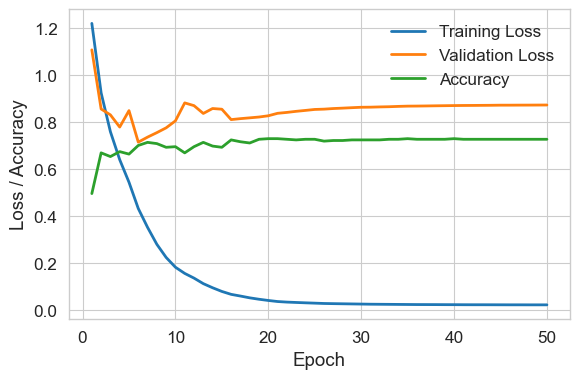

In [29]:
best_model_name = "comp_classifier_24-36_hdim36_param23366"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(best_model_loss['Epoch'], best_model_loss['Training Loss'], label='Training Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Validation Loss'], label='Validation Loss', linewidth=2)
plt.plot(best_model_loss['Epoch'], best_model_loss['Accuracy'], label='Accuracy', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('training_plot.pdf', dpi=300)  # Save as vector format
plt.show()

In [ ]:
# remove tensorboard logs from optimization
!rd /s /q f"{save_filepath}tensorboard_logs\\"

The system cannot find the file specified.
